In [4]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import timeit
import collections
import itertools
import matplotlib.pyplot as plt
from ripe_interface import (
    save_campaign,
    targets_to_dict,
    probes_to_dict,
    report_status,
    get_db,
    get_probes,
    scheduler,
    kill_all
)
from constants import blacklist
from ripe.atlas.sagan import traceroute
from pymongo.errors import BulkWriteError

# Select the name of the measurement

In [5]:
MEASUREMENT_NAME = 'sample01'  # Name of the database which will store the campagin

In [6]:
default_dir = '../../home/app/data/'

In [7]:
REAL_RUN = False

## Set a new database for the measurement

In [8]:
db = get_db(MEASUREMENT_NAME)

### Get all probes with ipv6 and sample for measurement

A new probes data frame is created by appending the selected probes

In [9]:
if db.probes.find({}).count() == 0:  # Don't send request again if probres are in db
    df = get_probes(clean=True)
    df.reset_index(level=0, inplace=True)
    df = df[~df.id.isin(blacklist)] # Exclude bad probes
    probes = (
        pd.DataFrame()
        .append(df[df.rir == 'AFRINIC'].sample(2, random_state=1), ignore_index=True)
        .append(df[df.rir == 'ARIN'].sample(2, random_state=1), ignore_index=True)
        .append(df[df.rir == 'RIPE NCC'].sample(2, random_state=1), ignore_index=True)
        .append(df[(df.rir == 'APNIC') & (df.cc != 'JP')].sample(1, random_state=1), ignore_index=True)
        .append(df[df.cc == 'JP'].sample(1, random_state=1), ignore_index=True)
        .append(df[df.rir == 'LACNIC'], ignore_index=True)
    )

    probes = probes[~probes.id.isin(probes[probes.cc == 'BR'].sample(10, random_state=1).id.tolist())] # Remove some brazilian probes
    probes.reset_index(drop=True, inplace=True) # renumber index
else:
    probes = pd.DataFrame(list(db.probes.find()))
    probes = probes.set_index('id')
    probes.reset_index(level=0, inplace=True)

## List of selected probes

In [10]:
probes.head()

,id,_id,address,asn,cc,prefix,rir
0,25283,59c9b4772249f80023e5e84b,2c0f:feb0:c:1::8,37100.0,ZA,2c0f:feb0::/32,AFRINIC
1,11327,59c9b4772249f80023e5e84c,2c0f:fbf0:11:0:fa1a:67ff:fe4d:836e,32653.0,ZA,2c0f:fbf0::/28,AFRINIC
2,10584,59c9b4772249f80023e5e84d,2601:989:4100:327:a2f3:c1ff:fec4:4f32,7922.0,US,2601::/20,ARIN
3,26758,59c9b4772249f80023e5e84e,2600:7400:1400:0:c66e:1fff:fe5b:eb02,29933.0,US,2600:7400::/28,ARIN
4,33448,59c9b4772249f80023e5e84f,2a01:e35:8b5a:61c0:d66e:eff:fe23:50e8,12322.0,FR,2a01:e00::/26,RIPE NCC


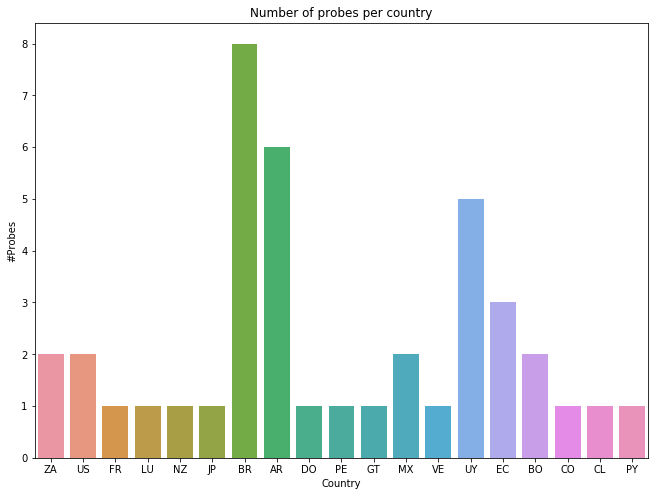

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(11,8)
sns.countplot(x='cc', data=probes, ax=ax)
ax.set_title('Number of probes per country')
ax.set_ylabel('#Probes')
ax.set_xlabel('Country')

## Save probes to database

In [ ]:
try:
    db.probes.insert_many(probes.to_dict(orient="records"))
except BulkWriteError:
    pass
print 'Probes in database: ', db.probes.find({}).count()

### Select some random IPv6 in LATAM to hit

In [ ]:
with open(default_dir + 'final_hitlist.csv', 'r') as f:
    hitlist = []
    while len(hitlist) < 2: # Some some hitlist
        l = f.readline().strip()
        hitlist.append(l)

In [ ]:
hitlist

## Start creating campaing

#### Begin by creating probes list

In [ ]:
probes_to_use = probes_to_dict(probes.id.tolist())
print 'Example dict: ', probes_to_use[0]
print 'Probes to use: ', len(probes_to_use)

#### Then create hitlist dicts

In [ ]:
ips_to_dict = targets_to_dict([x.decode('unicode-escape') for x in hitlist])
print ips_to_dict[0]

In [ ]:
report_status(db) # Status of database before creation of campaing

Because each descriptor holds 50 probes, we except to have only 5 descriptors

In [ ]:
save_campaign(target_list=ips_to_dict,
             probe_list=probes_to_use,
              db=db,
             tag='LATAM01',
             description='Using 5 real ips and all latam probes')

It returns all errors, so empty is good :)

We check the status of our database and everything is allright

In [ ]:
report_status(db)

In [ ]:
TOTAL = db.campaign_descriptor.find({'status':'waiting'}).count()

In [ ]:
if REAL_RUN:
    if (db.campaign_descriptor.find({'status':'waiting'}).count() == 0 and 
       db.campaign_descriptor.find({'status':'ongoing'}).count() == 0):
        print 'Campaing finished'
    else:
        start_time = timeit.default_timer()
        for i in itertools.count():
            scheduler(db,wait_time=5,sleep_time=1)
            if db.campaign_descriptor.find({'status':'finished'}).count() == TOTAL:
                break
        endtime = timeit.default_timer() - start_time
        print endtime

## Get results statistics

In [ ]:
db.results.find().count()

Get list of results:

In [ ]:
result_list = list(db.results.find())
processed_results = [traceroute.TracerouteResult(x) for x in result_list]

Augment probes dataframe with new responses:

In [ ]:
counted_responses = collections.Counter([x.origin for x in processed_results if not x.is_error])
probes['responses'] = probes['address'].map(counted_responses)

In [ ]:
blacklist = probes[probes.responses < 2].id.tolist()
print blacklist

Plot diferences with original data:

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11,8)
sns.countplot(x='cc', data=probes, ax=ax, color='red', label='All')
sns.countplot(x='cc', data=probes[probes.responses > 0], ax=ax, color='green', label='Working')
ax.set_title('Number of probes per country')
ax.set_ylabel('#Probes')
ax.set_xlabel('Country')

### Create dataframe to study tracerotues

In [ ]:
df_traceroutes = pd.DataFrame(result_list)
df_traceroutes['hops'] = df_traceroutes['result'].map(lambda x: len(x))
df_traceroutes.drop([u'size',
                  u'timestamp',
                  u'type',
                  u'group_id',
                  u'msm_id',
                  u'msm_name',
                  u'paris_id',
                  u'fw',
                  u'af',
                  u'endtime',
                  u'dst_name',
                  u'proto',
                  u'lts',
                  u'result'
                 ],
                 1,
                 inplace=True
                )

In [ ]:
df_traceroutes.head()

In [ ]:
sns.countplot(x='hops',data=df_traceroutes)